# Treinamento do modelo para predição de temperatura

## Configurações

In [1]:
# Define paths to model files
import os
MODELS_DIR = 'models/'
if not os.path.exists(MODELS_DIR):
    os.mkdir(MODELS_DIR)

tflite_model_name = 'temperature_model' 
c_model_name = 'temperature_model' 

## Preparação do ambiente

Importar bibliotecas

In [2]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
from sklearn.model_selection import train_test_split

seed = 1
np.random.seed(seed)
tf.random.set_seed(seed)

## Dataset

### 1. Importar dados

Dados obtidos por meio do sensor MPU-6050

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
df = pd.read_csv('drive/MyDrive/EEL7323/temp.csv')
df["id"] = df.index % 10

df_reshape = pd.DataFrame()
columns = ['t1', 't2', 't3', 't4', 't5', 't6', 't7', 't8', 't9', 'target']
for i in range(10):
  df_reshape[columns[i]] = list(df.loc[df['id'] == i, 'temperature'])

df_reshape.head()

,t1,t2,t3,t4,t5,t6,t7,t8,t9,target
0,32.14,32.14,32.14,32.14,32.14,32.14,32.14,32.14,32.14,32.14
1,32.14,32.14,32.14,32.14,32.14,32.14,32.14,32.14,32.14,32.14
2,32.14,32.14,32.14,32.14,32.14,32.14,32.14,32.14,32.14,33.14
3,33.19,33.19,33.19,33.19,33.19,33.19,33.19,33.29,33.54,34.06
4,34.23,34.24,34.24,34.24,34.24,34.24,34.24,34.24,34.24,34.24


### 2. Separação dos dados

Os dados serão separados em:
  1. Treino: 60%
  2. Validação: 20%
  3. Teste: 20% 




In [5]:
df_train, df_val_test = train_test_split(df_reshape, test_size=0.4, random_state=1)
df_val, df_test = train_test_split(df_val_test, test_size=0.2, random_state=1)

In [6]:
X_train = np.array(df_train.drop('target', axis = 1))
X_val = np.array(df_val.drop('target', axis = 1))
X_test = np.array(df_test.drop('target', axis = 1))
y_train = np.array(df_train['target'])
y_val = np.array(df_val['target'])
y_test = np.array(df_test['target'])

## Treinamento

### 1. Definição do modelo


In [7]:
model = tf.keras.Sequential()

model.add(keras.layers.Dense(16, activation='relu', input_shape=(9,)))

model.add(keras.layers.Dense(1))

model.compile(optimizer='adam', loss='mse', metrics=['mae'])

### 2. Treinamento do modelo




In [8]:
# Train the model on our training data while validating on our validation set
history = model.fit(X_train, y_train, epochs=500, batch_size=64,
                        validation_data=(X_val, y_val))

Epoch 1/500
3/3 [==============================] - 1s 151ms/step - loss: 389.7017 - mae: 19.4329 - val_loss: 362.5760 - val_mae: 18.7701
Epoch 2/500
3/3 [==============================] - 0s 17ms/step - loss: 333.3375 - mae: 17.9637 - val_loss: 306.6144 - val_mae: 17.2609
Epoch 3/500
3/3 [==============================] - 0s 29ms/step - loss: 280.5462 - mae: 16.4816 - val_loss: 255.5976 - val_mae: 15.7595
Epoch 4/500
3/3 [==============================] - 0s 37ms/step - loss: 232.8837 - mae: 15.0138 - val_loss: 209.6015 - val_mae: 14.2711
Epoch 5/500
3/3 [==============================] - 0s 19ms/step - loss: 189.6463 - mae: 13.5536 - val_loss: 168.7393 - val_mae: 12.8044
Epoch 6/500
3/3 [==============================] - 0s 27ms/step - loss: 151.9996 - mae: 12.1283 - val_loss: 132.9381 - val_mae: 11.3647
Epoch 7/500
3/3 [==============================] - 0s 26ms/step - loss: 118.8708 - mae: 10.7241 - val_loss: 102.2106 - val_mae: 9.9645
Epoch 8/500
3/3 [==============================]

### 2. Avaliação dos resultados

**1. Evolução das perdas no treinamento**

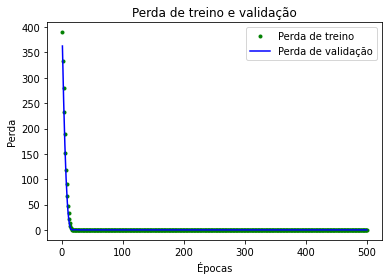

In [9]:
# Draw a graph of the loss, which is the distance between
# the predicted and actual values during training and validation.
train_loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(train_loss) + 1)

plt.plot(epochs, train_loss, 'g.', label='Perda de treino')
plt.plot(epochs, val_loss, 'b', label='Perda de validação')
plt.title('Perda de treino e validação')
plt.xlabel('Épocas')
plt.ylabel('Perda')
plt.legend()
plt.show()

**2. Comparação com os resultados**

1/1 [==============================] - 0s 101ms/step


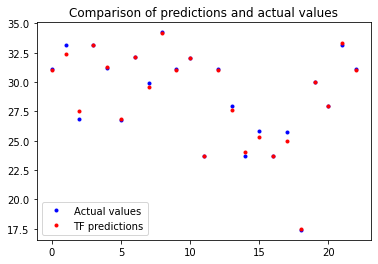

In [10]:
# Calculate and print the loss on our test dataset
test_loss, test_mae = model.evaluate(X_test, y_test)

y_test_pred = model.predict(X_test)
y_test_pred = np.concatenate([l for l in y_test_pred], axis=0)

plt.title('Comparison of predictions and actual values')
plt.plot(range(len(y_test)), y_test, 'b.', label='Actual values')
plt.plot(range(len(y_test)), y_test_pred, 'r.', label='TF predictions')
plt.legend()
plt.show()

## Gerar modelo para o microcontrolador

In [11]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()

open(tflite_model_name + '.tflite', 'wb').write(tflite_model)

2148

In [12]:
def hex_to_c_array(hex_data, var_name):

  c_str = ''

  # Create header guard
  c_str += '#ifndef ' + var_name.upper() + '_H\n'
  c_str += '#define ' + var_name.upper() + '_H\n\n'

  # Add array length at top of file
  c_str += '\nunsigned int ' + var_name + '_len = ' + str(len(hex_data)) + ';\n'

  # Declare C variable
  c_str += 'unsigned char ' + var_name + '[] = {'
  hex_array = []
  for i, val in enumerate(hex_data) :

    # Construct string from hex
    hex_str = format(val, '#04x')

    # Add formatting so each line stays within 80 characters
    if (i + 1) < len(hex_data):
      hex_str += ','
    if (i + 1) % 12 == 0:
      hex_str += '\n '
    hex_array.append(hex_str)

  # Add closing brace
  c_str += '\n ' + format(' '.join(hex_array)) + '\n};\n\n'

  # Close out header guard
  c_str += '#endif //' + var_name.upper() + '_H'

  return c_str

In [13]:
with open(c_model_name + '.h', 'w') as file:
  file.write(hex_to_c_array(tflite_model, c_model_name))